# Section 9 - Clustering Models: K-Means and Gaussian Mixture Models (GMM)

You should have downloaded:
- t1_icbm_normal_1mm_pn3_rf20.rawb
- utils.py

Goals:
- Review lecture content
- Understand K-Means and GMM via hands-on coding

## 0 Introduction

```t1_icbm_normal_1mm_pn3_rf20.rawb``` contains MR images of cross-sections of the brain.

The collection of images is defined as a 3D tensor of shape (H, W, C), where 
- H = height of image
- W = width of image
- C = number of cross-sections scanned

Moreover, images are represented on a gray scale, i.e., each image has only one color channel with pixel values in the range ```[0, 255]```.

**Goal:** based on the MRI, segment/cluster regions of the brain that seem to be similar. 

## 1 Warm-up exercise

Load the MRI Brain data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Image_raw = np.fromfile("t1_icbm_normal_1mm_pn3_rf20.rawb",  dtype=np.uint8)
Image = np.reshape(Image_raw,(181,217,181),order='F') # hard coded dimensions

### 1.1 Heuristic Clustering
**Task:**

Plot the **80th cross section** using `plot_cross_sect_with_threshold`, which is imported from a separate file. 

Experiment with a range of specified ranges:
- threshold1=80 and threshold2=160 (split into roughly equal thirds)
- threshold1=80 and threshold2=140 (keep first third, but lower threshold2 )
- threshold1=70 and threshold2=120 (yet another similar option, which will make more sense when you see the histogram later)

**Discuss:**
- How did the thresholds affect the plots? Were some better than others in visualizing the brain regions that look similar?
- Imagine the thresholds were not given to you as above, how would you go about efficiently segmenting the brain regions? Can you automate it? How?

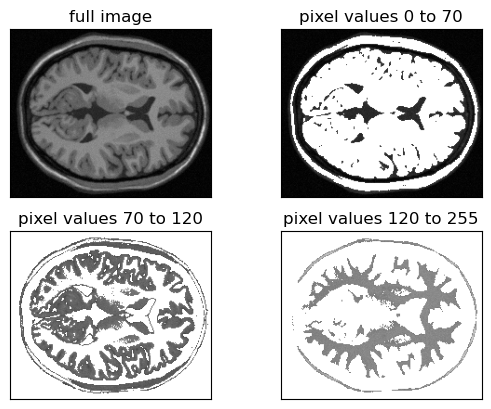

In [2]:
from utils import plot_cross_sect_with_threshold

plot_cross_sect_with_threshold(img=Image[:,:,80], threshold1=70, threshold2=120)    # TODO

### 1.2 Histogram
To see why the third option (threshold1=70 and threshold2=120) gave the most convincing segmentation, take a look at the histogram of pixel values over all cross sections.

**Key point:** it is tedious to have to *manually* do these segmentation/clustering. That is one reason why we want to "automate" it through clustering algorithms, such as k-means and gaussian mixture models.

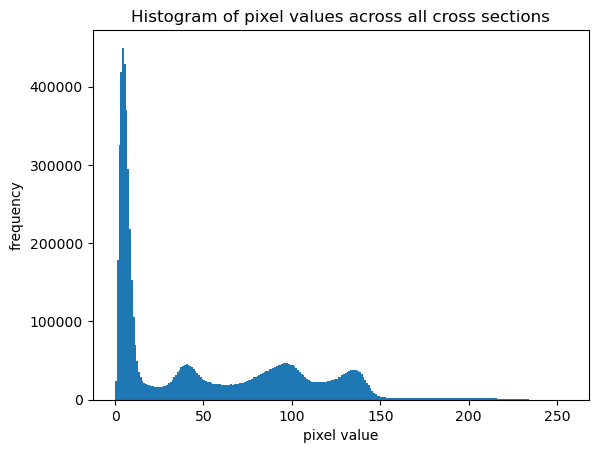

In [3]:
H = plt.hist(Image.flatten(), bins=255)
plt.title("Histogram of pixel values across all cross sections")
plt.xlabel('pixel value'); plt.ylabel('frequency')
plt.show()

## 2 K-means

### 2.1 Recap
*Adapted from: Wikipedia <a href=https://en.wikipedia.org/wiki/K-means_clustering>K-means Clustering</a>*

K-Means is a method used to partition data into $k$ cluster/groups of similar observations. 

### 2.2 Training
- **Centroid.** Each cluster i has a center, a.k.a. centroid $\mu_i$.
- **How to compute centroid.** Given a partition of the _training_ data into $k$ clusters $G = (G_1, G_2, \dotsi, G_k)$, the centroid is simply the average location of all points in the same cluster.
    - The k-means clusters is the **optimal partition that minimizes the sum of (squared) distances to the centroids**.
    $$\argmin_{G} \sum_{i=1}^k \sum_{x \in G_i} ||x - \mu_{i}||^2$$
    - In other words, the goal of k-means is to minimize the within-cluster variance. 

#### Iterative method for training
**Task:** fill in the blanks
1. **Initialize centroid.** Choose initial set of <u>clusters centroids</u> $(\mu_1, \dots, \mu_k)$. Often, we just randomly pick $k$ data points as the initial centroids.

2. **Assign points.** For each training point, assign it to <u>closest</u> cluster centroid.
<!-- $$\displaystyle G_{i}^{(t)} = \{x_j: ||x_m - \mu_{i}^{(t)}||^2 \leq ||x_m - \mu_{j}^{(t)}||^2, \ j = 1, \dotsi, k\}$$ -->

3. **Update centroid.** Recalculate each cluster's centroid as the <u>mean</u> of all points assigned to the cluster.
<!-- >$\displaystyle \mu_{i}^{(t+1)} = \dfrac{1}{|G_{i}^{(t)}|}\sum_{x \in G_{i}^{(t)}}x_i$ -->

4. **Repeat until <u>convergence</u> or <u>maximum number of iterations</u>.**

### 2.3 Hands-on implementation
**Task:** complete the code below for implementing k-means.
- `initialize` has been done for you and is imported from a separate file.
- `assign`
- `update`
- `my_kmeans`, which combines all steps of k-means

In [4]:
from utils import initialize

def assign(X, centroids):
    """
    Assign data points to the nearest cluster centroids.

    Parameters:
        X        (1D numpy array): MRI voxels
        centroids(1D numpy array): Current cluster centroids.

    Returns:
        clusters (1D numpy array): Cluster assignments for each data point.
    """
    # Calculate the  distance between data points and centroids.
    dist = np.abs(X[:,np.newaxis] - centroids)  # TODO

    # Assign each data point to the cluster with the nearest centroid.
    clusters = np.argmin(dist, axis=1)          # TODO

    return clusters


def update(X, clusters, num_cluster):
    """
    Update cluster centroids based on the assigned data points.

    Parameters:
        X        (1D numpy array): MRI voxels
        clusters (1D numpy array): Cluster assignments for each data point.
        num_cluster         (int): Number of clusters.

    Returns:
        new_centroids (1D numpy array): Updated cluster centroids.
    """
    new_centroids = np.zeros(num_cluster)
    
    # Iterate through each cluster.
    for k in range(num_cluster):
        # Calculate the mean of data points in the current cluster and update the centroid.
        new_centroids[k] = np.mean(X[clusters == k])         # TODO

    return new_centroids


def my_kmeans(X, num_cluster):
    """
    Perform the K-Means clustering algorithm on input data.

    Parameters:
        X (1D numpy array): MRI voxels
        num_cluster  (int): Number of clusters.

    Returns:
        clusters  (1D numpy array): Cluster assignments for each data point.
        centroids (1D numpy array): cluster centroids.
    """
    iter, max_iter = 0, 10

    centroids, _, _ = initialize(X, num_cluster)
    clusters = assign(X, centroids)
    while iter <= max_iter:
        centroids = update(X, clusters, num_cluster)       # TODO
        clusters  = assign(X, centroids)                   # TODO
        iter += 1

    return clusters, centroids

**Task:**
- run kmeans on the full image to segment the image into 4 clusters.
- plot the clusters on the 80th cross section image. Compare it against the manual thresholding you did earlier.

In [5]:
X = np.ravel(Image)

num_clusters = 4
clustered_X_kmeans, centroids = my_kmeans(X, num_clusters)      # TODO
clustered_image_kmeans = np.reshape(clustered_X_kmeans, (181,217,181))
centroids

array([  6.17882461,  45.81445607,  93.17764558, 140.18696273])

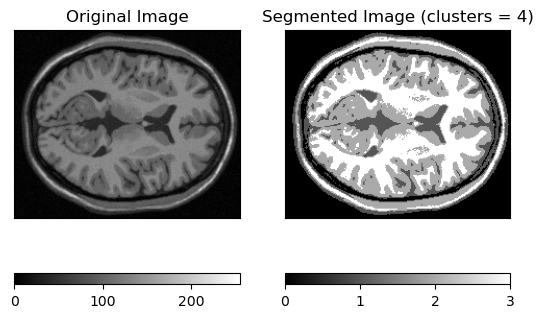

In [6]:
slice_idx = 80
from utils import plot_original_image, plot_segmented_image

# Original image
plt.subplot(1,2,1)
plot_original_image(Image, slice_idx)

# Clustered image
plt.subplot(1,2,2)
plot_segmented_image(clustered_image_kmeans, slice_idx)

## 3 Gaussian Mixture Model (GMM)
### 3.1 Recap
*Adapted from: Matt Bonakdarpour, <a href=https://stephens999.github.io/fiveMinuteStats/intro_to_em.html>"Introduction to EM: Gaussian Mixture Models."</a>*


A Gaussian Mixture Model is a probabilistic model that represents the data as a mixture of $k$ Gaussian distributions, each with unknown parameters $\theta$. 

For example, suppose you have a dataset and you assume that it can be modeled as a mixture of two Gaussians ($k = 2$). Then, your model would have the following parameters:
- $(\pi_1, \mu_1,\sigma_1)$
- $(\pi_2, \mu_2,\sigma_2)$ 

where $\pi_{k}, \mu_{k}, \sigma_{k}$ are the prior, the mean and the variance for each Gaussian, and $\pi_1\!+\!\pi_2\!=\!1$. plus latent cluster assigment variables (explained below).

### 3.2 Training
**Goal:** find the set of parameters that **maximize the likelihood function**. 

Assuming our observations $x_1, \dots, x_n$ are i.i.d., the likelihood function is:
$$L(\theta;x) = \prod_{i=1}^n \Big[\pi_1\, \mathcal{N}\left(x_i;\mu_1,\sigma_1\right) + \pi_2 \, \mathcal{N}\left(x_i; \mu_2,\sigma_2\right)\Big],$$
which we can simplify further by applying a *log* to change products into sums
$${\color{red}{\log}} \ L(\theta;x) = {\color{red}{\sum_{i=1}^n \log}}\Big[\pi_1\, \mathcal{N}\left(x_i;\mu_1,\sigma_1\right) + \pi_2 \, \mathcal{N}\left(x_i; \mu_2,\sigma_2\right)\Big].$$

#### Iterative method for training
- However, maximizing the log-likelihood function does not have a closed form/analytic solution
- we need to make use of an iterative method to optimize the parameters. 
- For GMMs, the go to method is the **Expectation-Maximization Algorithm (EM)**.

**Task:** fill in the blanks
1. **Initialize.** Choose initial <u>parameters $\theta$</u>, can be done randomly or using result from k-means.
2. **Update (EM).** Compute a better $\theta'$ s.t. the <u>log-likelihood</u> improves: $\log L(\theta';x) > \log L(\theta;x)$. (Can also swap likelihood for posterior.)
3. **Repeat until <u>convergence</u> or <u>maximum number of iterations</u>.**

### 3.3 How Update (EM) works
#### 1. E-step 
Define a **new random variable $Z_i$**, which represents the cluster assigment of data point $i$
- So, ${\color{red}{P(Z_i = k | x_i)}}$ is the posterior probability that data point $i$ belongs to cluster $k$, given the specific observed value $x_i$.
- **Bayes rule** to compute $P(Z_i = k | x_i)$ with current parameters $\mu_k, \sigma_k, \pi_k$
$$ {\color{red}{P(Z_i = k | x_i)}} \ = \ \frac{{\color{blue}{P(x_i | Z_i = k)}}{\color{orange}{P(Z_i = k)}}}{P(x_i)} \ = \ \frac{{\color{orange}{\pi_k}} {\color{blue}{\mathcal{N}(x_i;\mu_k, \sigma_{k})}}}{\sum_{k=1}^{K}\pi_k \mathcal{N}(x_i;\mu_k, \sigma_{k})}$$

#### 2. M-step
**Update parameters**

For convenience, **define $N_k$** (which can be thought of as "the number of points assigned to cluster $k$")
$$ N_k := \sum_{i=1}^n {\color{red}{P(Z_i = k | x_i)}}.$$
The updates are:
$$
\begin{align*}
    \mu'_k    &= \dfrac{1}{N_k} \sum_{i=1}^n {{x_i}} {\color{red}{P(Z_i = k | x_i)}}\\
    {\sigma^2_k}' &= \dfrac{1}{N_k}\sum_{i=1}^n {{(x_i - \mu_k)^2}} {\color{red}{P(Z_i = k | x_i)}}\\
    \pi'_k    &= \dfrac{N_k}{n}
\end{align*}
$$

#### 3. Repeat if necessary
**Check.** Evaluate log likelihood using new parameters $\mu'_k, {\sigma_k}', \pi'_k$.
- Stop if:
    - converges (i.e., log-likelihood has only increases by less than some small $\epsilon$)
    - max iterations reached
- Otherwise, repeat steps E and M.

### 3.4 Hands-on Implementation of k-means
In the code below, we use `gamma[i,k]` to represent $P(Z_i = k | x_i)$.

**Task:** complete the code below to implement the EM algorithm and Gaussian Mixture Models for clustering.
- `expectation`
- `maximization`
- `log_likelihood`, which has been done for you
- `my_GMM`

In [7]:
from scipy.stats import norm
from utils import plot_gmm_steps


def expectation(X, mu, var, prior):
    """
    Estimates the cluster membership probabilities (posterior)
      for each voxel* in a 3D MRI volume.
    (*: Voxel is the analogue of a pixel in 3D.)

    Parameters:
        X     (1D numpy array): MRI voxels
        mu    (1D numpy array): cluster means
        var   (1D numpy array): cluster variances
        prior (1D numpy array): cluster prior probabilities

    Returns:
        gamma (2D numpy array: num_voxels x num_clusters): 
            cluster membership probabilities for each voxel 
    """
    num_clusters = len(mu)
    gamma = np.zeros((len(X), num_clusters))
    normalizing_constant = np.zeros(len(X))

    # Calculate unnormalized cluster probabilities
    for k in range(num_clusters):
        norm_dist = norm.pdf(X, loc=mu[k], scale=np.sqrt(var[k]))  # TODO
        gamma[:,k] = prior[k] * norm_dist                    # TODO
        normalizing_constant += gamma[:,k]

    # Normalize probabilities
    for k in range(num_clusters):
        gamma[:,k] /= normalizing_constant                           # TODO

    return gamma

def maximization(X, gamma):
    """
    Updates the cluster mean, variance, and prior probability according to the latest class membership.

    Parameters:
        X     (1D numpy array): MRI voxels
        gamma (2D numpy array: num_voxels x num_clusters): 
            cluster membership probabilities for each voxel  

    Returns:
        mu    (1D numpy array): updated cluster means
        var   (1D numpy array): updated cluster variances
        prior (1D numpy array): updated cluster prior probabilities
    """
    N_k = np.sum(gamma, axis=0)         # TODO
    # mu
    mu = np.sum(X[:,np.newaxis] * gamma, axis=0) / N_k      # TODO
    # var
    var = np.sum(((X[:,np.newaxis] - mu) ** 2) * gamma, axis=0) / N_k        # TODO
    # prior
    prior = N_k / len(X)                          # TODO

    return mu, var, prior

def log_likelihood(X, mu, var, prior):
    """
    Estimates the total log-likelihood for the image labeling.

    Parameters:
        X     (1D numpy array): MRI voxels
        mu    (1D numpy array): cluster means
        var   (1D numpy array): cluster variances
        prior (1D numpy array): cluster prior probabilities

    Returns:
        log_likelihood (float)
    """
    num_clusters = len(mu)
    likelihood_terms = np.zeros(len(X))

    for k in range(num_clusters):
        norm_dist = norm.pdf(X, loc=mu[k], scale=np.sqrt(var[k]))
        likelihood_terms += prior[k] * norm_dist

    log_likelihood = np.sum(np.log(likelihood_terms))
    return log_likelihood

def my_GMM(X, n_cluster):
    """
    Run the Gaussian Mixture Model on the image data.

    Parameters:
        X    (1D numpy array): MRI voxels
        n_cluster   (integer): Number of clusters

    Returns:
        mu    (1D numpy array): cluster means
        var   (1D numpy array): cluster variances
        prior (1D numpy array): cluster prior probabilities
        clustered_X (1D numpy array): cluster for each voxel, based on largest likelihood
    """

    iter, max_iter = 0, 8
    error = []

    mu, var, prior = initialize(X, n_cluster)
    while iter < max_iter:
        # EM steps
        gamma = expectation(X, mu, var, prior)      # TODO
        mu, var, prior = maximization(X, gamma)     # TODO

        # check likelihood
        cost = log_likelihood(X, mu, var, prior)    # TODO
        error.append(cost)

        # plot
        plot_gmm_steps(X, mu, var, prior, error, max_iter)
        
        iter += 1

    # choose best cluster and sort for convenience
    clustered_X = np.argmax(gamma, axis=1)
    sort_ind = np.argsort(mu)
    return clustered_X, mu[sort_ind], var[sort_ind], prior[sort_ind]

**Task:**
- run gmm on the full image to segment the image into 4 clusters.
- plot the clusters on the 80th cross section image. Compare it against the manual thresholding you did earlier.
- Try num_clusters = 4, 5, 6. What differences do you observe?

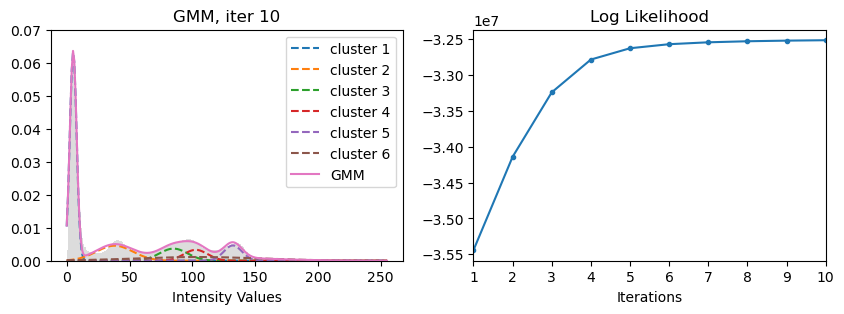

In [8]:
num_clusters = 6
clustered_X_gmm, mu, var, cluster_prior = my_GMM(X,num_clusters)
clustered_image_gmm = np.reshape(clustered_X_gmm,(181,217,181))

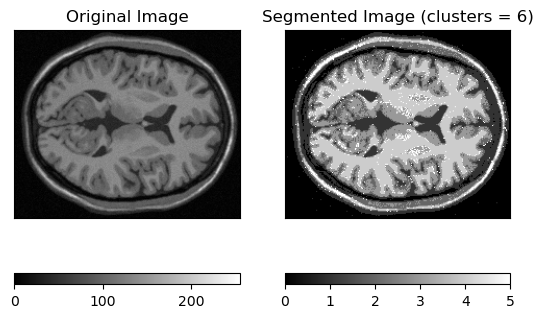

In [9]:
slice_idx = 80

# Original image
plt.subplot(1,2,1)
plot_original_image(Image, slice_idx)

# Clustered image
plt.subplot(1,2,2)
plot_segmented_image(clustered_image_gmm, slice_idx)

#### 3.5 (Optional) Comparison against sklearn implementation
Note: cluster labels may look different, but they cuold just be a reordering of numbers.

In [10]:
from sklearn.mixture import GaussianMixture

# sklearn
gmm = GaussianMixture(n_components=6)
gmm.fit(X.reshape(-1,1))
Cpred = gmm.predict(X.reshape(-1,1))

# reshape for plotting
clustered_image_gmm_sklearn = np.reshape(Cpred, (181,217,181))

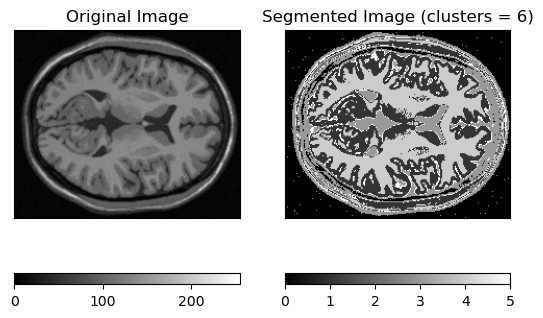

In [11]:
slice_idx = 80

# Original image
plt.subplot(1,2,1)
plot_original_image(Image, slice_idx)

# Clustered image
plt.subplot(1,2,2)
plot_segmented_image(clustered_image_gmm_sklearn, slice_idx)